In [1]:
import os
import sqlite3
import pprint
from datetime import datetime
import ast
import numpy as np
import pandas as pd 

date_format = "%Y-%m-%d %H:%M:%S.%f"
failure_list = ["dependency", "divide_zero", "environment", "manager_kill", "memory", "node_kill", "ulimit", "worker_kill"]

def get_failure_type(workflow_cnt, repeat=10):
    i = workflow_cnt//repeat
    if i >= len(failure_list):
        return "unknown"
    else:
        return failure_list[i]
    
def sorted_walk(top):
    for root, dirs, files in os.walk(top):
        dirs.sort()
        yield root, dirs, files

def find_and_process_stderr_files(root_directory):
    for root, _, files in os.walk(root_directory):
        aggregated_data = []

        for file in files:
            if file.endswith('stderr'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    for line in f:
                        if 'aggregated_dic' in line:
                            try:
                                # extract aggregated_dic
                                start_index = line.index('aggregated_dic =') + len('aggregated_dic =')
                                dict_str = line[start_index:].strip()
                                aggregated_dic = ast.literal_eval(dict_str)
                                aggregated_data.append(aggregated_dic)
                            except (ValueError, SyntaxError):
                                continue
        
        if aggregated_data:
            # calculate mean
            keys = aggregated_data[0].keys()
            avg_data = {key: np.mean([d[key] for d in aggregated_data if isinstance(d[key], (int, float))]) for key in keys if isinstance(aggregated_data[0][key], (int, float))}
            return avg_data


def process_workflow(runs_directory):
    workflow_list = []
    
    for root, dirs, files in sorted_walk(runs_directory):
        if 'monitoring.db' in files:
            info = {}
            db_path = os.path.join(root, 'monitoring.db')
            try:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()

                info['db_dir'] = db_path

                # get run_id
                cursor.execute("SELECT run_id FROM workflow")
                rows = cursor.fetchall()
                info['run_id'] = rows[0][0]

                # get failure type
                info['failure_type'] = get_failure_type(len(workflow_list))

                # get success or not
                cursor.execute("SELECT task_fail_history FROM try WHERE task_id IS 5")
                rows = cursor.fetchall()
                info['success'] = False
                if len(rows) > 0:
                    for row in rows:
                        if row[0] == "":
                            info['success'] = True
                            break

                # get resource dict
                script_path = os.path.join(root, dirs[0], 'submit_scripts')
                info['resource_dict'] = find_and_process_stderr_files(script_path)
                
                conn.close()
            except sqlite3.Error as e:
                print(f"Error reading {db_path}: {e}")
            finally:
                workflow_list.append(info)
    
    return workflow_list


In [2]:
plain_list = process_workflow('without')
plain_df = pd.DataFrame(plain_list)
plain_df

,db_dir,run_id,failure_type,success,resource_dict
0,without/failure-injection-2024-06-20-13-05-52/...,789f42d8-eeb8-494d-80a4-98ef59160cef,dependency,True,{'psutil_process_memory_percent': 1.8409801051...
1,without/failure-injection-2024-06-20-13-08-38/...,95bb5275-5eb7-4d2a-8e53-d37980bd73b1,dependency,True,None
2,without/failure-injection-2024-06-20-13-09-03/...,04cb6f4d-1144-4aa3-a7fb-19b82aa6000d,dependency,True,None
3,without/failure-injection-2024-06-20-13-09-45/...,3eb0bcd1-4b1a-41b7-82a8-f09e0c5bcdb0,dependency,True,None
4,without/failure-injection-2024-06-20-13-11-50/...,74ab6eed-41bc-4cda-a70a-90adcb96fad6,dependency,True,{'psutil_process_memory_percent': 1.8026579573...
...,...,...,...,...,...
75,without/failure-injection-2024-06-20-15-18-53/...,a66e3099-04f7-40e3-9ade-f6b667c1782a,worker_kill,True,None
76,without/failure-injection-2024-06-20-15-19-57/...,6649d6e7-50ed-4f03-8878-14ac4c6caca9,worker_kill,True,None
77,without/failure-injection-2024-06-20-15-20-59/...,99a3866f-6b46-4a00-adc8-6e628dbf7682,worker_kill,True,None
78,without/failure-injection-2024-06-20-15-22-01/...,09ad791a-91fd-491d-afa2-dae90d7987b2,worker_kill,True,None


In [3]:
retry_list = process_workflow('with')
retry_df = pd.DataFrame(retry_list)
retry_df

,db_dir,run_id,failure_type,success,resource_dict
0,with/failure-injection-2024-06-20-10-52-35/par...,b58f36ab-c717-4410-a47a-d133373bf9ce,dependency,True,None
1,with/failure-injection-2024-06-20-10-52-53/par...,d1e772bf-ba0d-4248-bd7c-af602437e105,dependency,True,None
2,with/failure-injection-2024-06-20-10-53-07/par...,8811d0ae-1abe-40ef-9d0c-a2a0527143a7,dependency,True,None
3,with/failure-injection-2024-06-20-10-53-21/par...,29f71304-9cfa-42b1-9c4e-82817d4a3219,dependency,False,None
4,with/failure-injection-2024-06-20-10-53-40/par...,a69881fe-4552-4dee-942c-b9fb97148908,dependency,True,None
...,...,...,...,...,...
75,with/failure-injection-2024-06-20-12-57-55/par...,fdb8cc8d-abc8-4d3e-9f87-de935aca0aa0,worker_kill,True,None
76,with/failure-injection-2024-06-20-12-58-56/par...,326fb5b1-509b-4c07-9d48-d6d73bc2b7e8,worker_kill,True,None
77,with/failure-injection-2024-06-20-12-59-09/par...,f66cc88f-d234-4143-b63e-658f3e536a69,worker_kill,True,None
78,with/failure-injection-2024-06-20-12-59-55/par...,ad24b898-6a94-47e2-9474-be2b8a32c830,worker_kill,True,None


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def draw_resource(resource_type):
    # 确保 'resource_dict' 被展开为独立列
    plain_df_filtered = plain_df[plain_df['resource_dict'].notnull()]
    retry_df_filtered = retry_df[retry_df['resource_dict'].notnull()]
    plain_df_expanded = plain_df_filtered['resource_dict'].apply(pd.Series)
    retry_df_expanded = retry_df_filtered['resource_dict'].apply(pd.Series)

    # 计算均值和方差
    stats_df1 = plain_df_expanded.groupby(plain_df['failure_type'])[resource_type].agg(['mean', 'std']).reset_index()
    stats_df2 = retry_df_expanded.groupby(retry_df['failure_type'])[resource_type].agg(['mean', 'std']).reset_index()

    # 合并两个DataFrame
    merged_stats = pd.merge(stats_df1, stats_df2, on='failure_type', suffixes=('_df1', '_df2'))

    # 设置柱状图位置
    x = np.arange(len(merged_stats['failure_type']))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制df1的柱状图
    rects1 = ax.bar(x - width/2, merged_stats['mean_df1'], width, yerr=merged_stats['std_df1'], label='plain_retry', color='skyblue')

    # 绘制df2的柱状图
    rects2 = ax.bar(x + width/2, merged_stats['mean_df2'], width, yerr=merged_stats['std_df2'], label='resilience', color='lightgreen')

    # 添加一些文本用于标签、标题和自定义x轴刻度
    ax.set_xlabel('Failure Type')
    ax.set_ylabel(resource_type)
    ax.set_title(f'Mean and Std of {resource_type} by Failure Type')
    ax.set_xticks(x)
    ax.set_xticklabels(merged_stats['failure_type'])
    ax.legend()

    # 自动调整标签
    fig.tight_layout()

    # 显示图形
    plt.show()


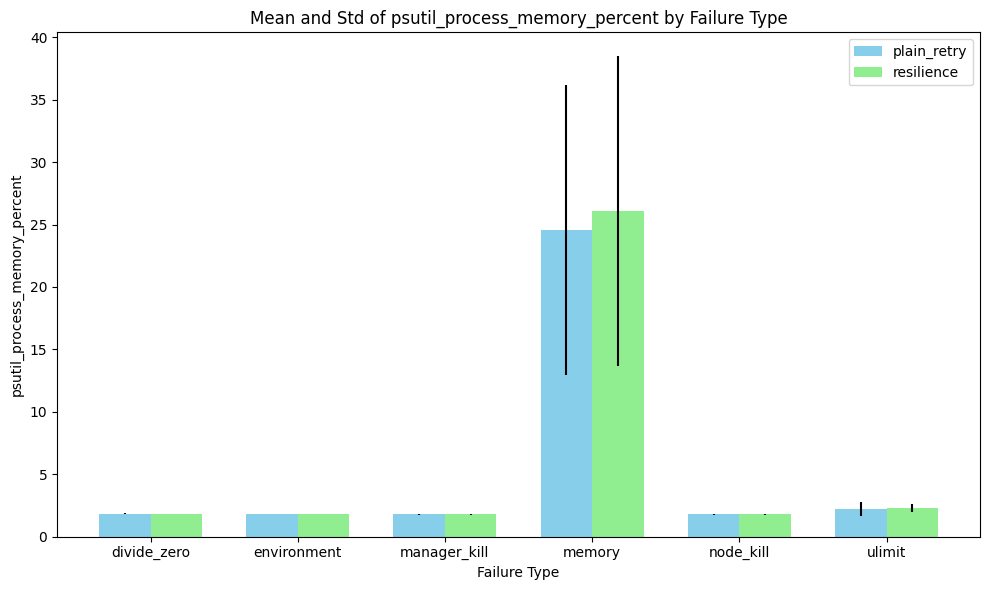

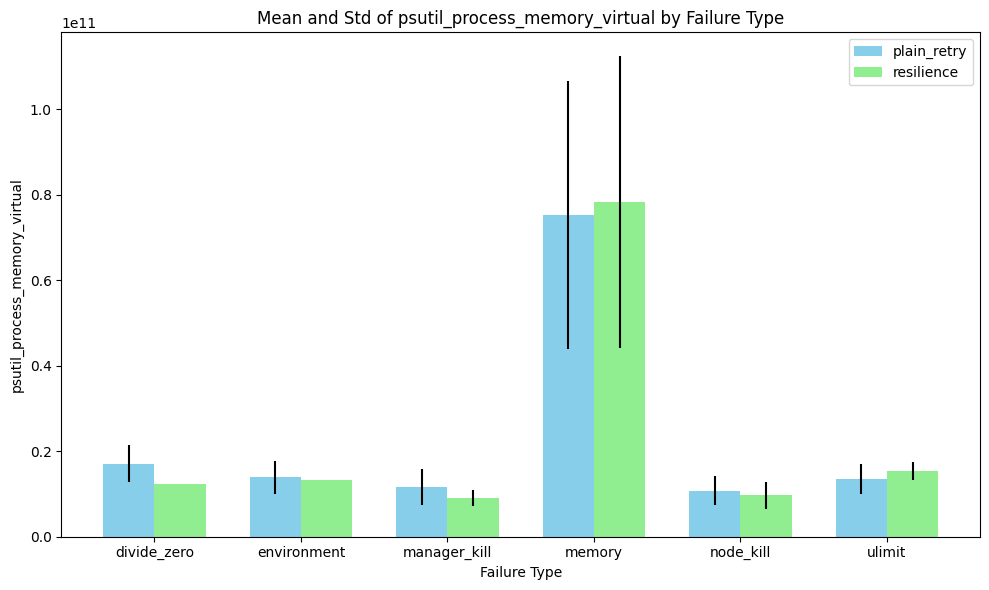

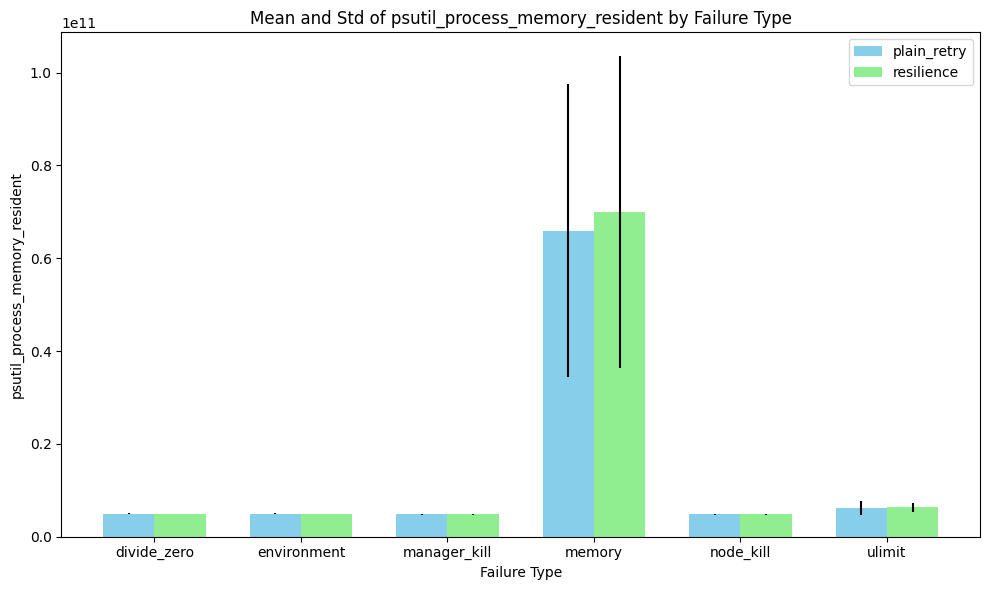

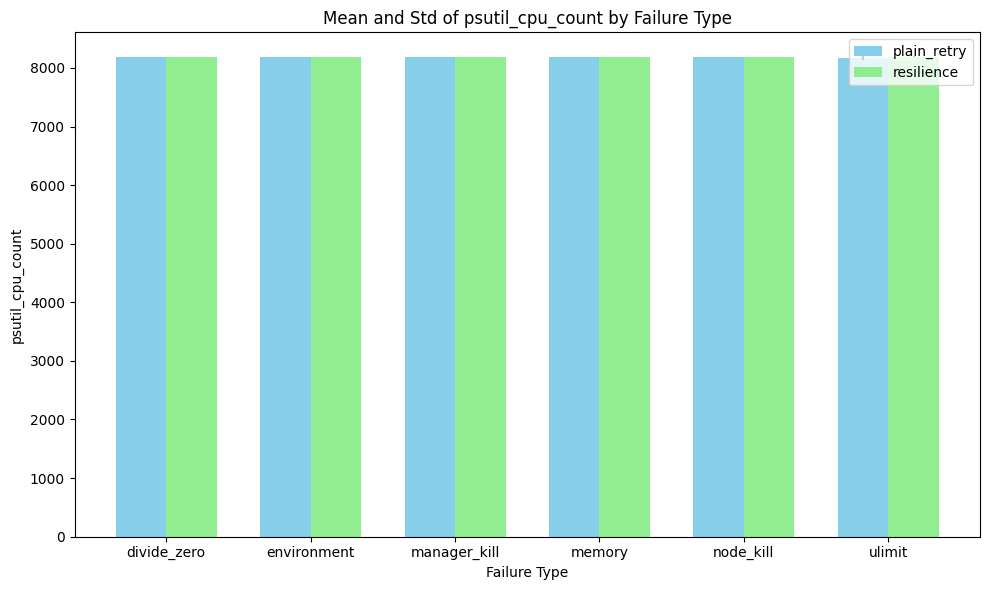

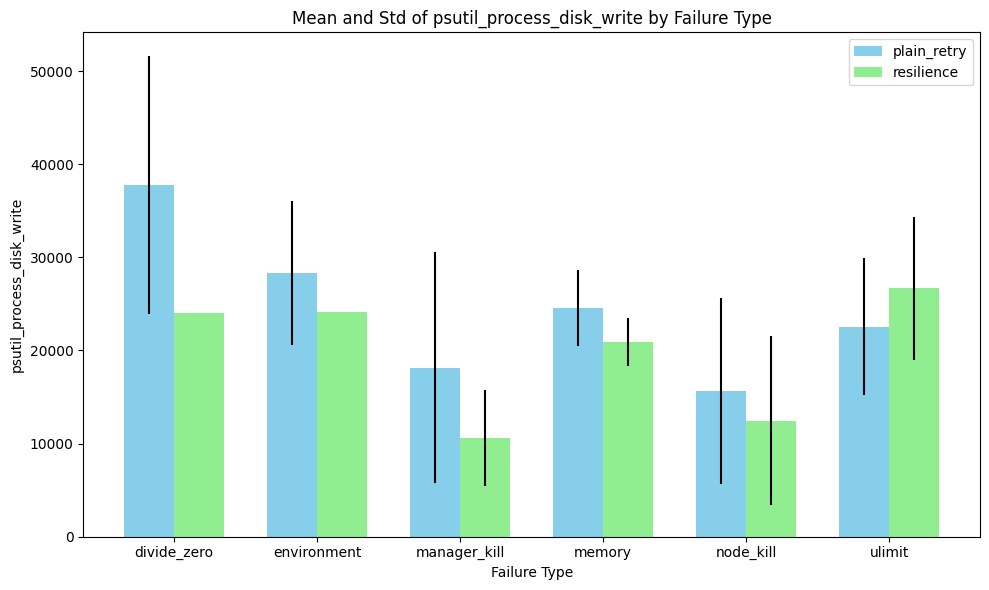

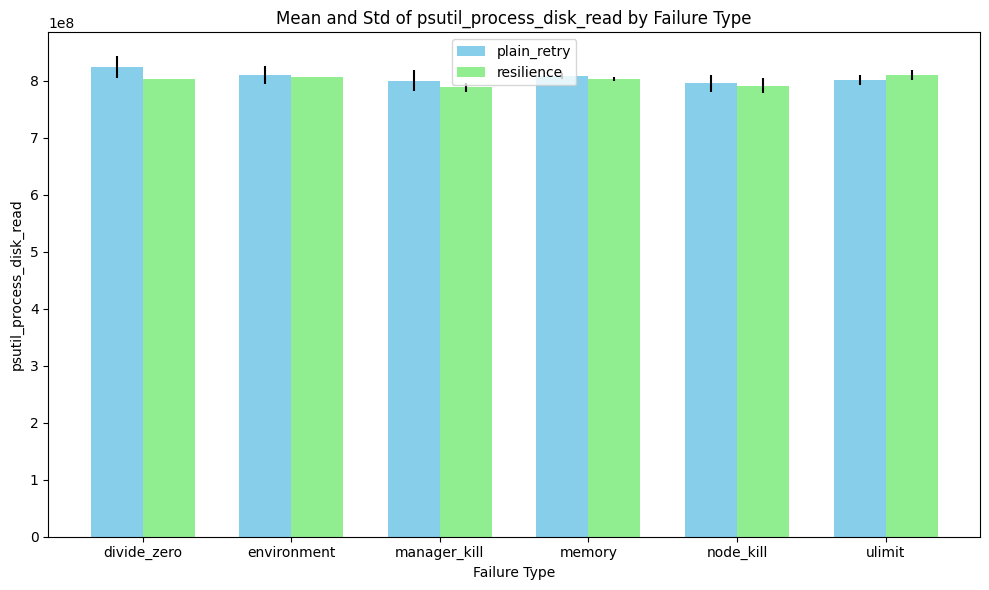

In [5]:
'''
aggregated_dic = {'psutil_process_memory_percent': 1.8277814490970075, 
'psutil_process_memory_virtual': 14785732608, 
'psutil_process_memory_resident': 4936781824, 
'psutil_cpu_count': 8192, 
'psutil_process_disk_write': 42615, 
'psutil_process_disk_read': 818231466, 
'hostname': 'exp-8-52', 
'executor_label': 'htex-1', 
'start_time': 1717169870.1731405}
'''
cal_list = ['psutil_process_memory_percent', 
            'psutil_process_memory_virtual',
            'psutil_process_memory_resident',
            'psutil_cpu_count',
            'psutil_process_disk_write',
            'psutil_process_disk_read']
for name in cal_list:
    draw_resource(name)